# Policy Evaluation

In [1]:
import numpy as np

## Gridworld Example

In [2]:
action_map = {
    "up": np.array([-1, 0]),
    "right": np.array([0, 1]),
    "down": np.array([1, 0]),
    "left": np.array([0, -1])
}


def get_pos(ix, length):
    """
    Get the position in a square Gridworld
    """
    col = ix % length
    row = ix // length
    state = np.asarray([row, col])
    return state

In [3]:
class Grid:
    def __init__(self, length):
        self.length = length
        self.action_map = {
            "up": np.array([-1, 0]),
            "right": np.array([0, 1]),
            "down": np.array([1, 0]),
            "left": np.array([0, -1])
        }
        self.action_ix = {action: ix for ix, action in enumerate(self.action_map)}

    def get_pos(self, ix):
        """
        Compute cartesian coordinates of the griworld given an index
        """
        col = ix % self.length
        row = ix // self.length
        position = np.asarray([row, col])
        return position
    
    def get_ix(self, position):
        row, col = position
        ix = self.length * row + col
        return ix
    
    def move_pos(self, pos, action):
        new_pos = pos + self.action_map[action]
        return new_pos
    
    def move(self, ix, action):
        position = self.get_pos(ix)
        new_position = self.move_pos(position, action)
        new_ix = self.get_ix(new_position)
        return new_ix
    
class GridV2(Grid):
    def __init__(self, length, terminal_states):
        super().__init__(length)
        self.terminal_states = terminal_states
    
    def _check_out_of_bounds(self, pos):
        x, y = pos
        return (x >= self.length) | (x < 0) | (y >= self.length) | (y < 0)
        return (state < 0) | (state >= self.length ** 2)
    
    def move(self, state, action):
        if state in self.terminal_states:
            return state
        position = self.get_pos(state)
        new_position = self.move_pos(position, action)
        is_oob = self._check_out_of_bounds(new_position)
        new_state = self.get_ix(new_position)    
        # is_oob = self._check_out_of_bounds(new_state)
        return state * is_oob + new_state * (1 - is_oob)

In [4]:
l = 4
terminal_states = np.array([0, 15])
gridworld = GridV2(l, terminal_states)

In [5]:
gridworld.move(15, "left")

15

In [6]:
n_actions = 4
n_rewards = 2
state_size = 4 ** 2

# s', r | s, a
p_gridworld = np.zeros((state_size, n_rewards, state_size, n_actions))
p_gridworld.shape

(16, 2, 16, 4)

In [7]:
# Gridworld representation
np.arange(16).reshape(4, 4)

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14, 15]])

In [8]:
actions = ["up", "right", "down", "left"]
for s in np.arange(state_size):
    for a in actions:
        s_prime = gridworld.move(s, a)
        r = 0 if s in terminal_states else -1
        a_ix = gridworld.action_ix[a]
        p_gridworld[s_prime, r, s, a_ix] = 1
        print(f"p(s'={s_prime:2}, r={r:2} | s={s:2}, a={a:5}) = 1")

p(s'= 0, r= 0 | s= 0, a=up   ) = 1
p(s'= 0, r= 0 | s= 0, a=right) = 1
p(s'= 0, r= 0 | s= 0, a=down ) = 1
p(s'= 0, r= 0 | s= 0, a=left ) = 1
p(s'= 1, r=-1 | s= 1, a=up   ) = 1
p(s'= 2, r=-1 | s= 1, a=right) = 1
p(s'= 5, r=-1 | s= 1, a=down ) = 1
p(s'= 0, r=-1 | s= 1, a=left ) = 1
p(s'= 2, r=-1 | s= 2, a=up   ) = 1
p(s'= 3, r=-1 | s= 2, a=right) = 1
p(s'= 6, r=-1 | s= 2, a=down ) = 1
p(s'= 1, r=-1 | s= 2, a=left ) = 1
p(s'= 3, r=-1 | s= 3, a=up   ) = 1
p(s'= 3, r=-1 | s= 3, a=right) = 1
p(s'= 7, r=-1 | s= 3, a=down ) = 1
p(s'= 2, r=-1 | s= 3, a=left ) = 1
p(s'= 0, r=-1 | s= 4, a=up   ) = 1
p(s'= 5, r=-1 | s= 4, a=right) = 1
p(s'= 8, r=-1 | s= 4, a=down ) = 1
p(s'= 4, r=-1 | s= 4, a=left ) = 1
p(s'= 1, r=-1 | s= 5, a=up   ) = 1
p(s'= 6, r=-1 | s= 5, a=right) = 1
p(s'= 9, r=-1 | s= 5, a=down ) = 1
p(s'= 4, r=-1 | s= 5, a=left ) = 1
p(s'= 2, r=-1 | s= 6, a=up   ) = 1
p(s'= 7, r=-1 | s= 6, a=right) = 1
p(s'=10, r=-1 | s= 6, a=down ) = 1
p(s'= 5, r=-1 | s= 6, a=left ) = 1
p(s'= 3, r=-1 | s= 7

In [20]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = "retina"

In [58]:

rewards = np.array([0,-1])
vk = np.zeros(state_size)

intermediate_ix = [1, 2, 3, 10]
intermediate_val_functions = []
val_change = []
Δ = np.inf
eps = 1e-6

counter = 0
while Δ > eps:
    single_reward = (rewards[None, :] + vk[:, None])
    # s', r | s, a
    vk_update = np.einsum("ijkl,ij->k", p_gridworld, single_reward) / 4
    # Δ = max(Δ, (vk - vk_update).max())
    Δ = np.abs(vk - vk_update).max()
    vk = vk_update
    
    val_change.append(Δ)
    
    counter += 1
    if counter in intermediate_ix:
        intermediate_val_functions.append(vk)

intermediate_val_functions.append(vk)
intermediate_ix.append(counter)

In [59]:
for k, vk in zip(intermediate_ix, intermediate_val_functions):
    print(f"{k=}")
    print(vk.reshape(4, 4).round(1), end="\n" * 2)

k=1
[[ 0. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1.  0.]]

k=2
[[ 0.  -1.8 -2.  -2. ]
 [-1.8 -2.  -2.  -2. ]
 [-2.  -2.  -2.  -1.8]
 [-2.  -2.  -1.8  0. ]]

k=3
[[ 0.  -2.4 -2.9 -3. ]
 [-2.4 -2.9 -3.  -2.9]
 [-2.9 -3.  -2.9 -2.4]
 [-3.  -2.9 -2.4  0. ]]

k=10
[[ 0.  -6.1 -8.4 -9. ]
 [-6.1 -7.7 -8.4 -8.4]
 [-8.4 -8.4 -7.7 -6.1]
 [-9.  -8.4 -6.1  0. ]]

k=258
[[  0. -14. -20. -22.]
 [-14. -18. -20. -20.]
 [-20. -20. -18. -14.]
 [-22. -20. -14.   0.]]



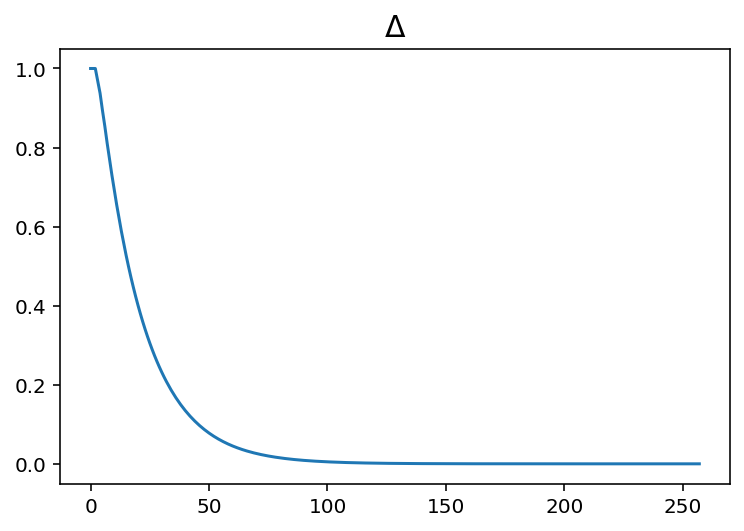

In [66]:
plt.plot(val_change)
plt.title(r"$\Delta$", fontsize=15);